In [1]:
import tensorflow as tf
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\DilThio\\Desktop\\reserach\\OCR\\OCR\\version 2\\myDataset",

    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 9602 files belonging to 50 classes.


In [4]:
class_names = dataset.class_names
class_names

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '6',
 '7',
 '8',
 '9']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[40  5 38 19 35 45  3 48 29 27 46 24 49 27  2 40 18 28 47  8 10 36 30 45
 40 28 43 47 29 24  6 25]


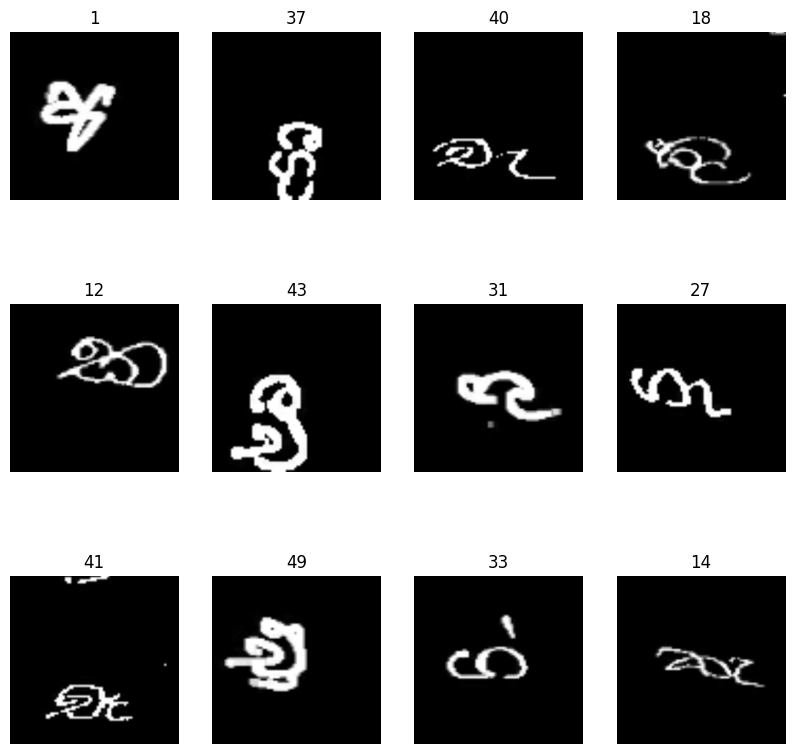

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

301

In [8]:
train_size = 0.8
len(dataset)*train_size

240.8

In [9]:
train_ds = dataset.take(21)
len(train_ds)

21

In [10]:
test_ds = dataset.skip(21)
len(test_ds)

280

In [11]:
val_size=0.1
len(dataset)*val_size

30.1

In [12]:
val_ds = test_ds.take(72)
len(val_ds)

72

In [13]:
test_ds = test_ds.skip(72)
len(test_ds)

208

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

240

In [17]:
len(val_ds)

30

In [18]:
len(test_ds)

31

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 454

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:


history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


240/240 [==============================] - 216s 851ms/step - loss: 4.1407 - accuracy: 0.0186 - val_loss: 3.9424 - val_accuracy: 0.0177
Epoch 2/50
240/240 [==============================] - 172s 716ms/step - loss: 3.9482 - accuracy: 0.0194 - val_loss: 3.9505 - val_accuracy: 0.0146
Epoch 3/50
240/240 [==============================] - 160s 666ms/step - loss: 3.9316 - accuracy: 0.0227 - val_loss: 3.9116 - val_accuracy: 0.0281
Epoch 4/50
240/240 [==============================] - 148s 616ms/step - loss: 3.9019 - accuracy: 0.0286 - val_loss: 3.8395 - val_accuracy: 0.0354
Epoch 5/50
240/240 [==============================] - 151s 630ms/step - loss: 3.8028 - accuracy: 0.0461 - val_loss: 3.6429 - val_accuracy: 0.0562
Epoch 6/50
240/240 [==============================] - 145s 604ms/step - loss: 3.6111 - accuracy: 0.0686 - val_loss: 3.3922 - val_accuracy: 0.0865
Epoch 7/50
240/240 [==============================] - 146s 606ms/step - loss: 3.4083 - accuracy: 0.0878 - val_loss: 3.2719

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 240}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
type(history.history['loss'])

list

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [32]:
val_acc

[0.01770833320915699,
 0.014583333395421505,
 0.02812499925494194,
 0.03541666641831398,
 0.05624999850988388,
 0.08645833283662796,
 0.10208333283662796,
 0.14374999701976776,
 0.1614583283662796,
 0.18645833432674408,
 0.2135416716337204,
 0.2593750059604645,
 0.24166665971279144,
 0.28437501192092896,
 0.2645833194255829,
 0.3187499940395355,
 0.3072916567325592,
 0.34583333134651184,
 0.36145833134651184,
 0.3697916567325592,
 0.3843750059604645,
 0.38854166865348816,
 0.4229166805744171,
 0.40312498807907104,
 0.41874998807907104,
 0.44999998807907104,
 0.44479167461395264,
 0.4572916626930237,
 0.421875,
 0.45104166865348816,
 0.46666666865348816,
 0.4749999940395355,
 0.4989583194255829,
 0.4572916626930237,
 0.484375,
 0.49687498807907104,
 0.5177083611488342,
 0.4895833432674408,
 0.518750011920929,
 0.4958333373069763,
 0.4989583194255829,
 0.518750011920929,
 0.5270833373069763,
 0.5229166746139526,
 0.49166667461395264,
 0.5291666388511658,
 0.5354166626930237,
 0.541666686

In [33]:
acc

[0.01861979253590107,
 0.01940104179084301,
 0.02265625074505806,
 0.02864583395421505,
 0.04609375074505806,
 0.06861979514360428,
 0.08776041865348816,
 0.12265624850988388,
 0.14114584028720856,
 0.16484375298023224,
 0.19127604365348816,
 0.20690104365348816,
 0.22486978769302368,
 0.24882812798023224,
 0.26875001192092896,
 0.27291667461395264,
 0.30286458134651184,
 0.3177083432674408,
 0.3303385376930237,
 0.34127604961395264,
 0.3532552123069763,
 0.3671875,
 0.38528645038604736,
 0.38854166865348816,
 0.39596354961395264,
 0.40312498807907104,
 0.4192708432674408,
 0.4273437559604645,
 0.42851561307907104,
 0.4377604126930237,
 0.4436197876930237,
 0.4442708194255829,
 0.45755207538604736,
 0.4700520932674408,
 0.46875,
 0.4778645932674408,
 0.4807291626930237,
 0.4876302182674408,
 0.5005208253860474,
 0.5013020634651184,
 0.5005208253860474,
 0.5013020634651184,
 0.5218750238418579,
 0.5149739384651184,
 0.5316406488418579,
 0.5305989384651184,
 0.5298177003860474,
 0.527864

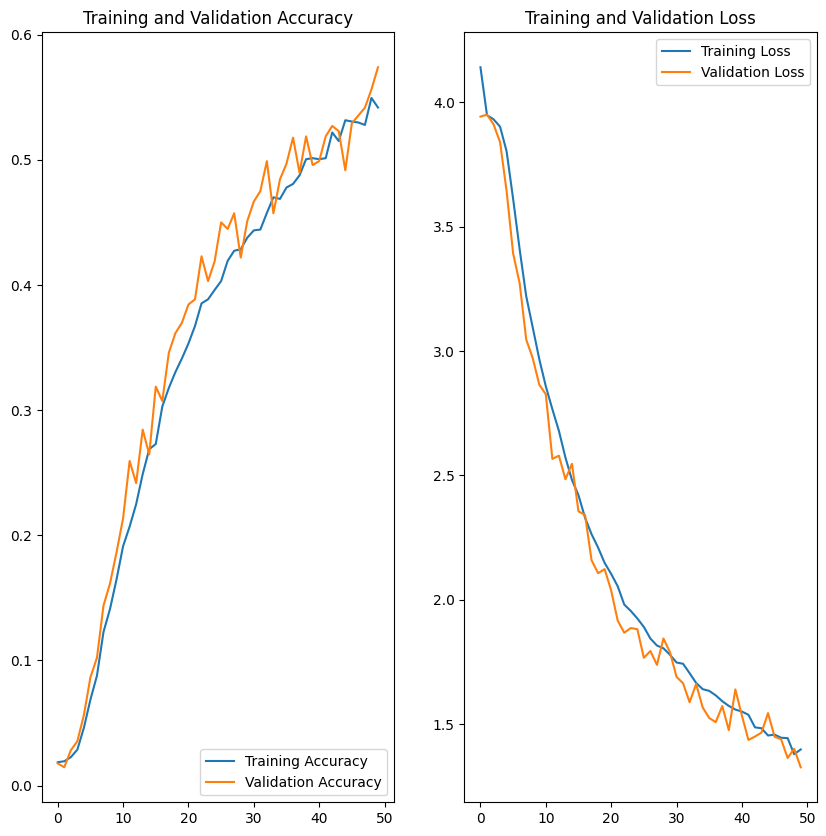

In [34]:
EPOCHS = 50

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: 29
1/1 [==============================] - 1s 727ms/step
Predictable Classes 25


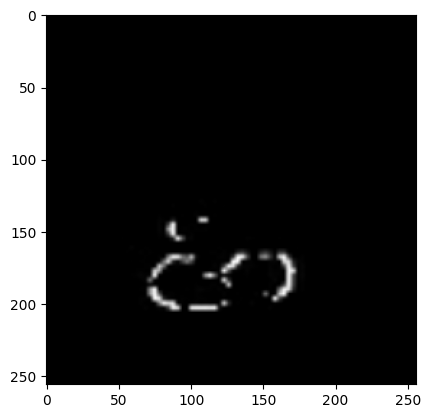

In [35]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("Predictable Classes",class_names[np.argmax(batch_prediction[0])])

In [15]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [16]:
import pandas as pd

def print_all_data(file_name):
    df = pd.read_excel(file_name)
    print(df)

def find_identity(file_name, number):
    df = pd.read_excel(file_name)
    identity = df.loc[df['FILENAME'] == number, 'IDENTITY'].values
    if len(identity) > 0:
        return identity[0]
    else:
        return None

file_name = 'C:/Users/DilThio/Desktop/reserach/OCR/OCR/version 2/letters.xlsx'
number = 1

while True:
    try:
        identity = find_identity(file_name, number)
        if identity:
            print(identity)
        else:
            print("Number not found in the file.")
    except ValueError:
        print("Please enter a valid number.")
    except Exception as e:
        print("An error occurred:", e)
    finally:
        choice = input("Do you want to continue? (yes/no): ")
        if choice.lower() != 'yes':
            break



අ


Found 9602 files belonging to 1 classes.


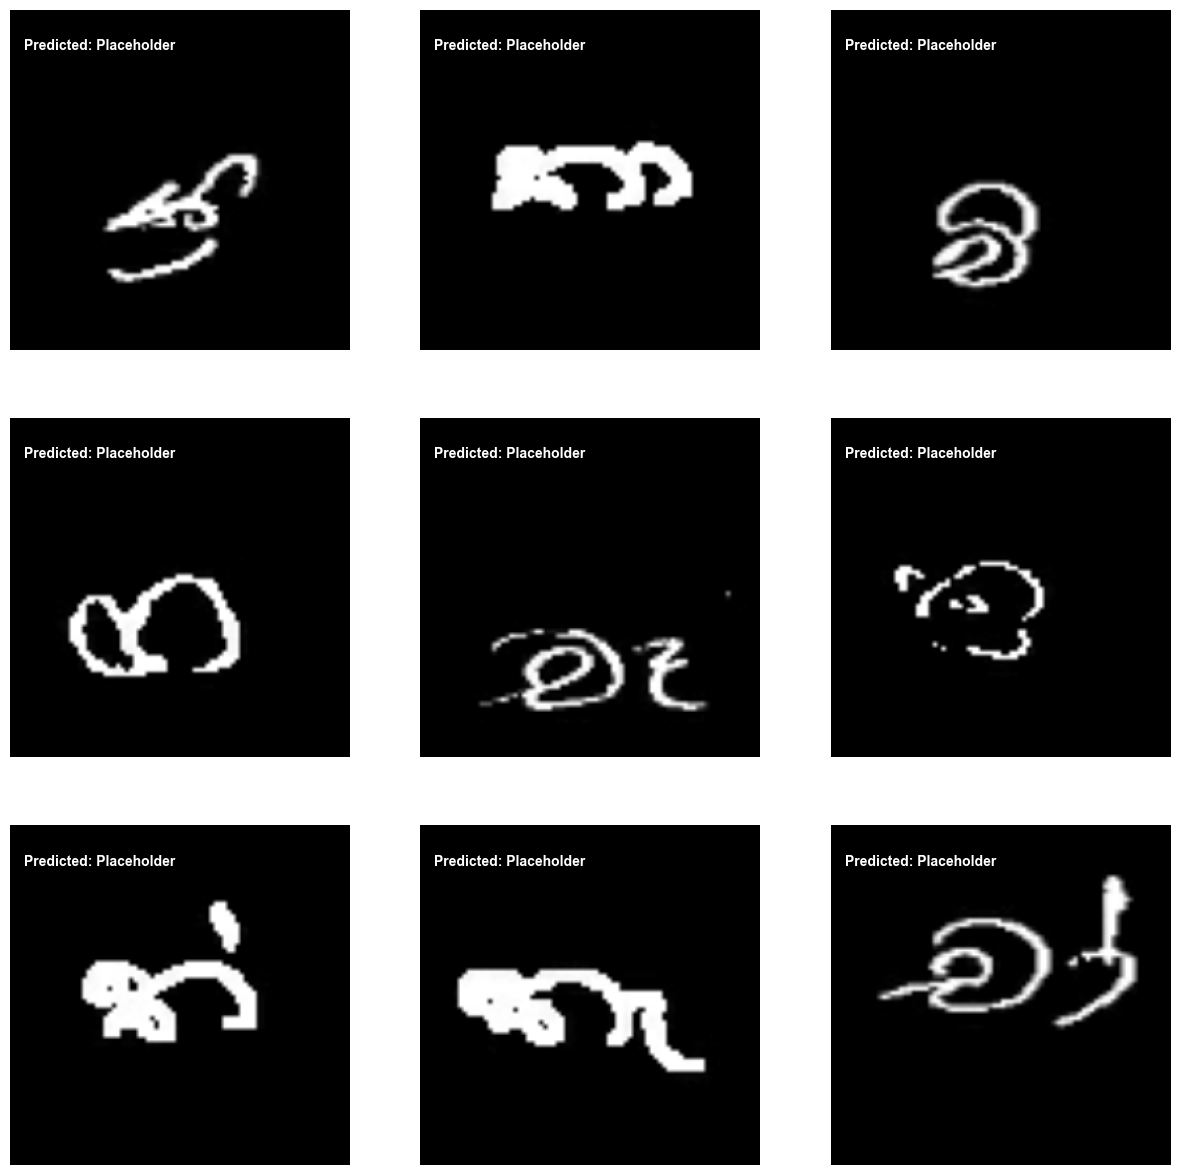

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# Specify the full path to the Noto Sans Sinhala font file
font_path = r'C:\Users\DilThio\AppData\Local\Microsoft\Windows\Fonts\NotoSansSinhala-Bold.ttf'  # Replace with the actual font file path

# Set the font properties for Matplotlib
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Load dataset from directory
dataset_path = r'C:\Users\DilThio\Desktop\reserach\OCR\OCR\version 2\myDataset'
batch_size = 32
image_size = (256, 256)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size,
)

# Your existing plotting code
plt.figure(figsize=(15, 15))
for images_batch in test_ds.take(1):  # Iterate over dataset batches
    for i in range(9):  # Display 9 images from the first batch
        plt.subplot(3, 3, i + 1)
        image = images_batch[i].numpy().astype("uint8")
        plt.imshow(image)
        
        # Placeholder for predicted class (replace it with your actual prediction logic)
        predicted_class = "Placeholder"
        
        # Display predicted class as text annotation
        plt.text(10, 30, f'Predicted: {predicted_class}', color='white', fontsize=10, fontweight='bold', backgroundcolor='black')
        
        plt.axis("off")
plt.show()



In [8]:
number = 0
while True:
    try:
        identity = find_identity(file_name, number)
        if identity:
            print(identity)
        else:
            print("Number not found in the file.")
    except ValueError:
        print("Please enter a valid number.")
    except Exception as e:
        print("An error occurred:", e)
    finally:
        choice = input("Do you want to continue? (yes/no): ")
        if choice.lower() != 'yes':
            break


An error occurred: name 'find_identity' is not defined


In [9]:
model_version =1
model.save(f"models/{model_version}")

NameError: name 'model' is not defined

Testing